In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab

## Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [2]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data

Here we read all the files and keep them as a list of strings, where each string is a single article

In [3]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print("\nDetected {} stories".format(len(news_stories)))
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print('{} words found in the total news set'.format(sum([len(story.split(' ')) for story in news_stories])))
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files



Detected 2225 stories


865163 words found in the total news set
Example words (start):  Windows worm travels with Tetris  Users are being 
Example words (end):  is years at Stradey as "the best time of my life."


## Build a Tokenizer

Here we build a tokenizer, that performs simple preprocessing like,

* Converting letters to lower case
* Removing punctuation

and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Generate labels for data

We generate a label using the filenames to train a classifier

In [5]:
labels_ser = pd.Series(filenames, index=filenames).str.split(os.path.sep, expand=True).iloc[:, -2].map(
    {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
)
labels_ser.head()

data/bbc/tech/272.txt    4
data/bbc/tech/127.txt    4
data/bbc/tech/370.txt    4
data/bbc/tech/329.txt    4
data/bbc/tech/240.txt    4
Name: 2, dtype: int64

## Create train/test split

Here we use 67% data as training and 33% as testing data.

In [6]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(labels_ser, test_size=0.33)

## Generating document embeddings

Here we write a function to generate document embeddings from the previous embedding arrays we saved to the disk for `skip-gram`, `CBOW` and `GloVe` algorithms.

In [7]:
def generate_document_embeddings(texts, filenames, tokenizer, embeddings):
    
    """ This function takes a sequence of tokens and compute the mean embedding vector \
    from the word vectors of all the tokens in the document """
    
    doc_embedding_df = [] # Contains document embeddings for all the articles
    assert isinstance(embeddings, pd.DataFrame), 'embeddings must be a pd.DataFrame'
    
    # This is a trick we use to quickly get the text preprocessed by the tokenizer
    # We first convert text to a sequences, and then back to text, which will give the
    # preprocessed tokens
    sequences = tokenizer.texts_to_sequences(texts)    
    preprocessed_texts = tokenizer.sequences_to_texts(sequences)
    
    # For each text,
    for text in preprocessed_texts:
        # Make sure we had matches for tokens in the embedding matrx
        assert embeddings.loc[text.split(' '), :].shape[0]>0
        # Compute mean of all the embeddings associated with words
        mean_embedding = embeddings.loc[text.split(' '), :].mean(axis=0)
        # Add that to list
        doc_embedding_df.append(mean_embedding)
        
    # Save the doc embeddings in a dataframe
    doc_embedding_df = pd.DataFrame(doc_embedding_df, index=filenames)
    
    return doc_embedding_df


## Compute skip-gram based document embeddings

In [20]:
# Load the skip-gram embeddings context and target
skipgram_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'context_embedding.pkl')
)
skipgram_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'target_embedding.pkl')
)
skipgram_context_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
NaN,-1.440415,1.375493,-1.205786,-1.326926,-1.336768,-1.205858,-1.366250,-1.036717,-1.365316,-0.775372,...,1.205486,1.138118,-1.385370,-1.264608,-1.437754,0.675243,1.440536,-1.003350,-1.371819,-1.189286
,-0.290653,0.574326,0.026581,-0.329045,-0.171542,0.224572,0.071370,0.146927,-0.041791,0.086741,...,0.259992,0.278289,-0.879627,-0.351423,-0.471852,0.385054,0.715421,-0.207442,-0.452972,-0.335440
the,-0.058531,0.310743,0.232947,-0.338871,-0.334953,0.003350,-0.061267,0.257632,0.031830,-0.587573,...,0.484254,-0.228630,-0.044630,-0.305802,-0.260530,-0.127028,0.003399,-0.336499,-0.092480,-0.006220
to,-0.276640,0.025122,-0.024782,-0.624656,-0.016077,0.046590,-1.094414,-0.848296,-0.327094,-1.684406,...,-0.261233,-0.106222,-0.139904,-0.411080,-0.546804,-0.629659,0.327903,0.008357,-0.131686,-0.281517
of,-0.281321,-0.034827,-0.068643,-0.210236,0.122180,0.021023,-0.258712,0.238127,-0.408491,-1.221611,...,0.083432,0.030410,-0.390671,-0.030053,-0.580829,-0.867796,0.258979,0.097112,-0.784424,-0.011228
and,-0.207726,0.023091,0.186237,-0.209033,-0.121335,0.271208,-0.033538,0.390482,0.217749,-1.416989,...,-0.351555,0.300373,-0.019044,-0.298739,0.010490,-0.531206,0.300045,-0.089004,0.077875,0.111504
a,-0.452312,0.305802,-0.962776,-0.884619,0.180468,-0.150204,-0.387859,0.362963,-0.194890,0.303527,...,-0.297423,0.582571,-0.498461,-0.074924,-0.178394,-0.163577,0.843274,0.606881,-0.164649,0.347022
in,0.264359,0.130696,0.374273,0.023650,-0.385127,0.085398,0.314853,-1.038579,-0.981065,0.308113,...,-0.258953,0.010786,-0.503573,0.038923,-0.188730,0.334766,0.095732,-0.019816,-0.184797,0.183958
for,-0.866129,0.162434,-0.183391,0.079462,-0.439157,-0.600472,-0.600996,-1.004945,-0.321327,-1.096564,...,0.153067,0.338188,-0.180635,0.506542,-1.126127,-0.499934,0.013070,-0.635006,-0.937275,0.183679
is,-0.004946,0.531260,-0.119664,-0.702005,-0.368837,-0.918419,0.164347,-0.694515,-0.470691,0.242414,...,0.780400,-0.017688,-0.529367,0.020786,-0.977541,-0.261291,0.011231,0.253999,-0.021428,-0.705856


In [8]:
# Compute the mean of context & target embeddings for better embeddings
skipgram_embeddings = (skipgram_context_embeddings + skipgram_target_embeddings)/2
# Generate the document embeddings with the average context target embeddings
skipgram_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, skipgram_embeddings)

## Train a document classifier

Here we train a simple document classifier, using document embeddings as inputs and labels we generated as targets. To get a consistent measure, we will run several trials.

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def get_classification_accuracy(doc_embeddings, train_labels, test_labels, n_trials):
    """ Train a simple MLP model for several trials and measure test accuracy"""
    
    accuracies = [] # Store accuracies across trials
    
    # For each trial
    for trial in range(n_trials):
        # Create a MLP classifier
        mlp_classifier = MLPClassifier(hidden_layer_sizes=(), max_iter=500)
        
        # Fit the model on training data
        mlp_classifier.fit(doc_embeddings.loc[train_labels.index], train_labels)
        
        # Get the predictions for test data
        predictions = mlp_classifier.predict(doc_embeddings.loc[test_labels.index])
    
        # Compute accuracy
        accuracies.append(accuracy_score(predictions, test_labels))
    
    return accuracies

# Get classification accuracy for skip-gram models
skipgram_accuracies = get_classification_accuracy(
    skipgram_doc_embeddings, train_labels, test_labels, n_trials=5
)

print("Skip-gram accuracies: {}".format(skipgram_accuracies))

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

Skip-gram accuracies: [0.8829931972789116, 0.8829931972789116, 0.8816326530612245, 0.8829931972789116, 0.8843537414965986]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on CBOW based document embeddings

In [11]:
cbow_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'context_embedding.pkl')
)
cbow_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'target_embedding.pkl')
)

cbow_embeddings = (cbow_context_embeddings + cbow_target_embeddings)/2
cbow_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, cbow_embeddings)

In [12]:
cbow_accuracies = get_classification_accuracy(
    cbow_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(cbow_accuracies)

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[0.8462585034013606, 0.8489795918367347, 0.8421768707482993, 0.8421768707482993, 0.8421768707482993]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on GloVe embeddings

In [13]:
glove_context_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'context_embedding_and_bias.pkl')
)
glove_target_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'target_embedding_and_bias.pkl')
)

glove_embeddings = (glove_context_embeddings.iloc[:, :-1] + glove_target_embeddings.iloc[:, :-1])/2
glove_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, glove_embeddings)

In [14]:
glove_accuracies = get_classification_accuracy(
    glove_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(glove_accuracies)

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[0.6870748299319728, 0.6816326530612244, 0.6938775510204082, 0.6870748299319728, 0.6938775510204082]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on ELMo document embeddings

In [21]:
elmo_doc_embeddings = pd.read_pickle(
    os.path.join('elmo_embeddings', 'elmo_embeddings.pkl')
)

elmo_doc_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
data/bbc/tech/272.txt,0.144291,0.015962,-0.151633,0.096555,-0.015913,0.075896,-0.033353,-0.118644,-0.192030,-0.124919,...,-0.418126,0.204618,0.007118,0.146415,0.010992,-0.005937,0.377529,-0.071118,0.302366,-0.099605
data/bbc/tech/127.txt,0.022870,-0.142899,-0.017096,-0.084165,0.320108,0.424914,-0.043930,0.257134,-0.215543,-0.046845,...,-0.219130,0.264653,0.020197,0.154055,0.091697,0.081720,0.279901,-0.111844,0.448175,0.007058
data/bbc/tech/370.txt,0.207623,0.058697,-0.008874,-0.088409,0.193419,0.046109,-0.107221,0.199647,-0.167632,0.003790,...,-0.054829,0.225892,0.052450,0.157943,-0.054407,0.171159,0.299693,0.078852,0.167330,-0.113994
data/bbc/tech/329.txt,0.022106,0.060943,-0.127390,-0.100214,0.184243,-0.077529,-0.157470,-0.042993,-0.204254,-0.021419,...,-0.337353,0.153419,0.052486,0.342915,0.268746,0.212994,0.665159,0.119243,0.474922,-0.215598
data/bbc/tech/240.txt,0.259128,-0.108082,0.076262,-0.080416,0.183988,0.329807,0.156697,0.495652,-0.104913,-0.120077,...,-0.218093,0.236378,0.076534,0.162548,0.025069,0.169282,0.229194,-0.025068,0.351246,0.069058
data/bbc/tech/379.txt,0.071111,-0.112660,0.038746,-0.084503,0.207438,0.231360,-0.015819,0.235174,-0.238940,0.030840,...,-0.330608,0.267756,0.072087,0.331695,0.015746,0.061020,0.361065,0.026556,0.360076,0.041994
data/bbc/tech/339.txt,0.080515,0.216040,-0.090722,0.118778,0.336153,0.223334,0.075926,0.472938,-0.046222,0.124439,...,-0.240382,0.015074,-0.299848,0.296837,0.031987,0.193828,0.271343,-0.176465,0.084201,-0.108979
data/bbc/tech/046.txt,0.019151,-0.029814,-0.046270,-0.139506,0.255929,0.230742,-0.011093,0.426066,0.112122,-0.130358,...,-0.285940,0.280919,-0.165248,0.348489,-0.034655,-0.099731,0.075747,-0.102612,0.101067,0.061966
data/bbc/tech/140.txt,0.379357,-0.174718,-0.062910,-0.017047,-0.034842,0.260822,0.129207,0.358961,-0.040298,-0.027103,...,-0.144901,0.096271,0.048004,0.026867,0.018682,-0.122255,0.306813,-0.069773,0.512123,0.125454
data/bbc/tech/349.txt,0.241237,-0.013553,0.033077,-0.159186,0.367290,0.414783,0.176808,0.556002,-0.273304,0.108183,...,-0.235471,0.265600,-0.005261,0.091303,0.124769,0.081303,0.202554,-0.067739,0.186223,0.080360


In [16]:
elmo_accuracies = get_classification_accuracy(
    elmo_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(elmo_accuracies)

[0.9727891156462585, 0.9741496598639455, 0.9727891156462585, 0.9741496598639455, 0.9755102040816327]


## Plot the accuracies of different models

Here we plot the accuracies from 5 trials, for different algorithms as box plots.

In [17]:
accuracy_df = pd.DataFrame(
    np.array([skipgram_accuracies, cbow_accuracies, glove_accuracies, elmo_accuracies]).T,
    columns = ['Skipgram', 'CBOW', "GloVe", "ELMo"]
)

accuracy_df.head()

,Skipgram,CBOW,GloVe,ELMo
0,0.882993,0.846259,0.687075,0.972789
1,0.882993,0.848980,0.681633,0.974150
2,0.881633,0.842177,0.693878,0.972789
3,0.882993,0.842177,0.687075,0.974150
4,0.884354,0.842177,0.693878,0.975510


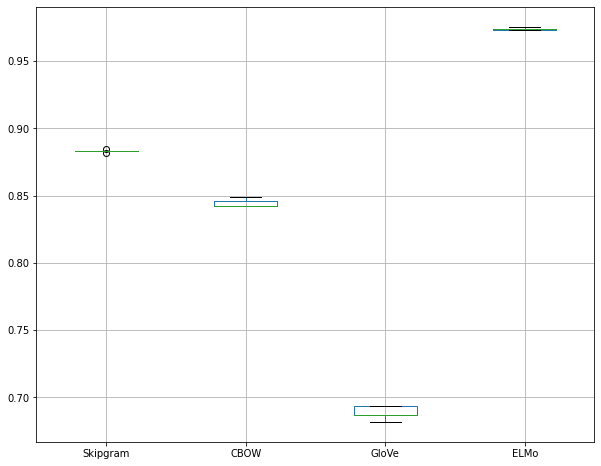

In [18]:
boxplot = accuracy_df.boxplot(figsize=(10,8))